# Background subtraction
In this notebook we match two pairs of images using LightGlue to generate a homography using Homography-est. Then we use Reinhard for color transfering and subtraction of the two images to generate a foreground mask that allows us to extract the insects.

In [1]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
mpath = '/content/drive/MyDrive/background_subtraction/'

In [ ]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("assets")

/content/LightGlue
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for lightglue (pyproject.toml) ... done


## Load extractor and matcher module
In this example we use SuperPoint features combined with LightGlue.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth" to /root/.cache/torch/hub/checkpoints/superpoint_v1.pth
100%|██████████| 4.96M/4.96M [00:00<00:00, 105MB/s]
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /root/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv.pth
100%|██████████| 45.3M/45.3M [00:00<00:00, 66.5MB/s]


# LightGlue point matching

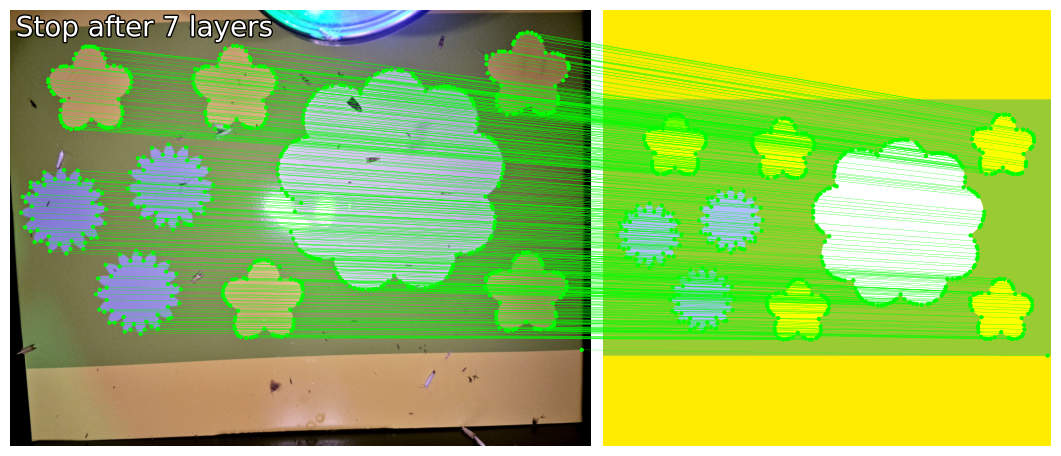

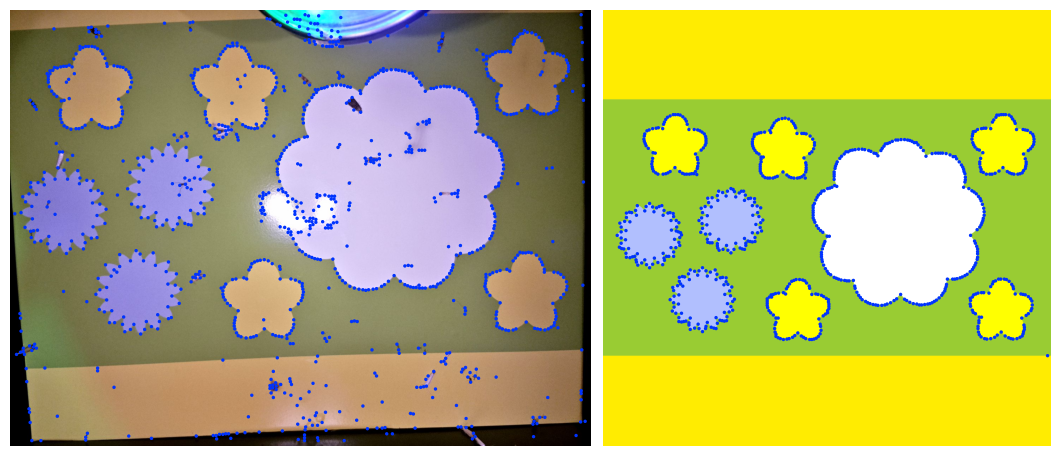

In [ ]:
image0 = load_image('/content/drive/MyDrive/diopsis_coco_split_flowers/20230714235848.jpg')
# image1 = load_image('/content/drive/MyDrive/diopsis_coco_split_flowers/flowers2.jpg')
image1 = load_image('/content/drive/MyDrive/diopsis_coco_split_flowers/flowers3.jpg')
# image1 = load_image('/content/drive/MyDrive/20230718225345.jpg')

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)

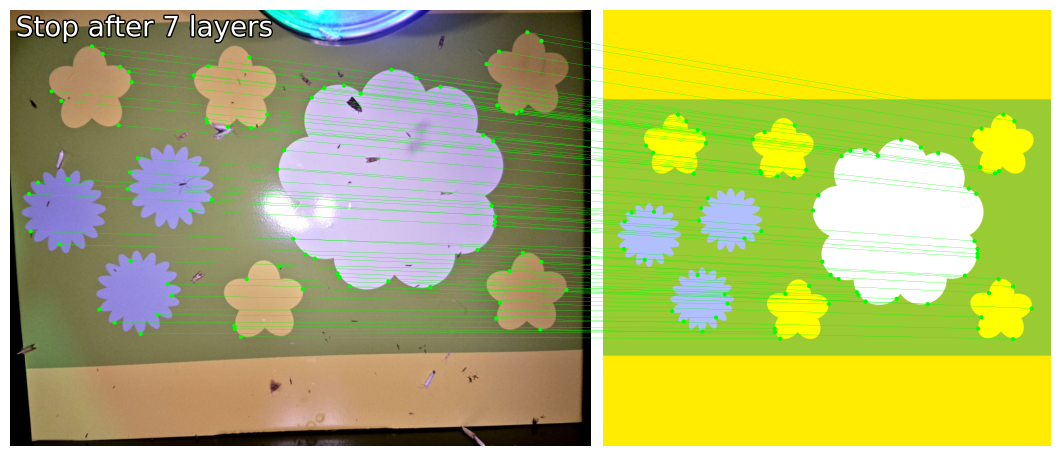

In [ ]:
axes = viz2d.plot_images([image0, image1])
# viz2d.plot_matches(np.concatenate([m_kpts0[:80].cpu(), m_kpts0[-80:].cpu()]), np.concatenate([m_kpts1[:80].cpu(), m_kpts1[-80:].cpu()]), color="lime", lw=0.2)
viz2d.plot_matches(m_kpts0[::len(m_kpts0)//80 + (len(m_kpts0) % 80 > 0)], m_kpts1[::len(m_kpts1)//80 + (len(m_kpts1) % 80 > 0)], color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

# Homography

In [ ]:
!sudo apt-get update
!sudo apt-get install -y libceres-dev libeigen3-dev
!pip install --quiet git+https://github.com/rpautrat/homography_est.git@17b200d528e6aa8ac61a878a29265bf5f9d36c41

!git clone https://github.com/cvg/GlueStick.git
%cd GlueStick

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [53.5 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,896 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [51.5 kB]
Hit:10 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,390 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,450 kB]
Get:13 https://ppa.launchpadcont

In [5]:
from gluestick.drawing import plot_images, plot_lines, plot_color_line_matches, plot_keypoints, plot_matches

In [ ]:
m_kpts0_arr = m_kpts0.cpu().numpy()
m_kpts1_arr = m_kpts1.cpu().numpy()

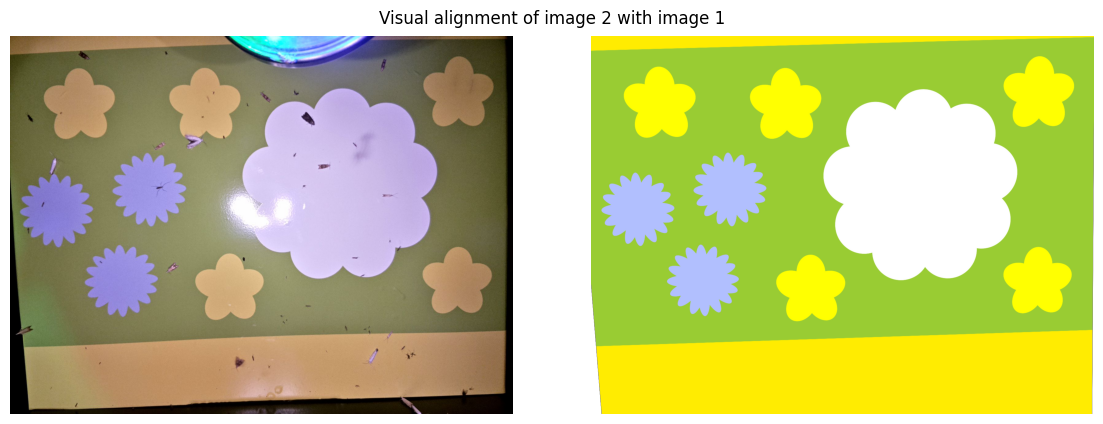

In [ ]:
import homography_est as hest

tol_px = 1.0
# H = hest.ransac_point_homography(np.concatenate([m_kpts0_arr[:30], m_kpts0_arr[-30:]]), np.concatenate([m_kpts1_arr[:30], m_kpts1_arr[-0:]]), tol_px, False, [])
H = hest.ransac_point_homography(m_kpts0_arr[::len(m_kpts0_arr)//80 + (len(m_kpts0_arr) % 80 > 0)], m_kpts1_arr[::len(m_kpts1_arr)//80 + (len(m_kpts1_arr) % 80 > 0)], tol_px, False, [])

color0 = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/diopsis_coco_split_flowers/20230714235848.jpg'), cv2.COLOR_BGR2RGBA)
# color1 = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/diopsis_coco_split_flowers/flowers2.jpg'), cv2.COLOR_BGR2RGBA)
color1 = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/diopsis_coco_split_flowers/flowers3.jpg'), cv2.COLOR_BGR2RGBA)
# color1 = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/20230718225345.jpg'), cv2.COLOR_BGR2RGBA)

warped = cv2.warpPerspective(color1, H, color0.shape[:2][::-1])

plot_images([color0, warped], pad=2.6)
plt.suptitle('Visual alignment of image 2 with image 1')
plt.show()

In [ ]:
cv2.imwrite('/content/drive/MyDrive/background_subtraction/clean_warped.jpg', cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

True

In [ ]:
# load image
img = cv2.imread('/content/drive/MyDrive/background_subtraction/clean_warped.jpg')
hh, ww = img.shape[:2]

# threshold
lower = (0,0,0)
upper = (255,255,255)
thresh = cv2.inRange(img, lower, upper)

# # apply open morphology
# #kernel = np.ones((5,5), np.uint8)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
# morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
# morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# get bounding box coordinates from largest external contour
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv2.contourArea)

# draw white filled contour on black background
mask = np.zeros((hh,ww), dtype=np.uint8)
cv2.drawContours(mask, [big_contour], 0, 255, cv2.FILLED)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

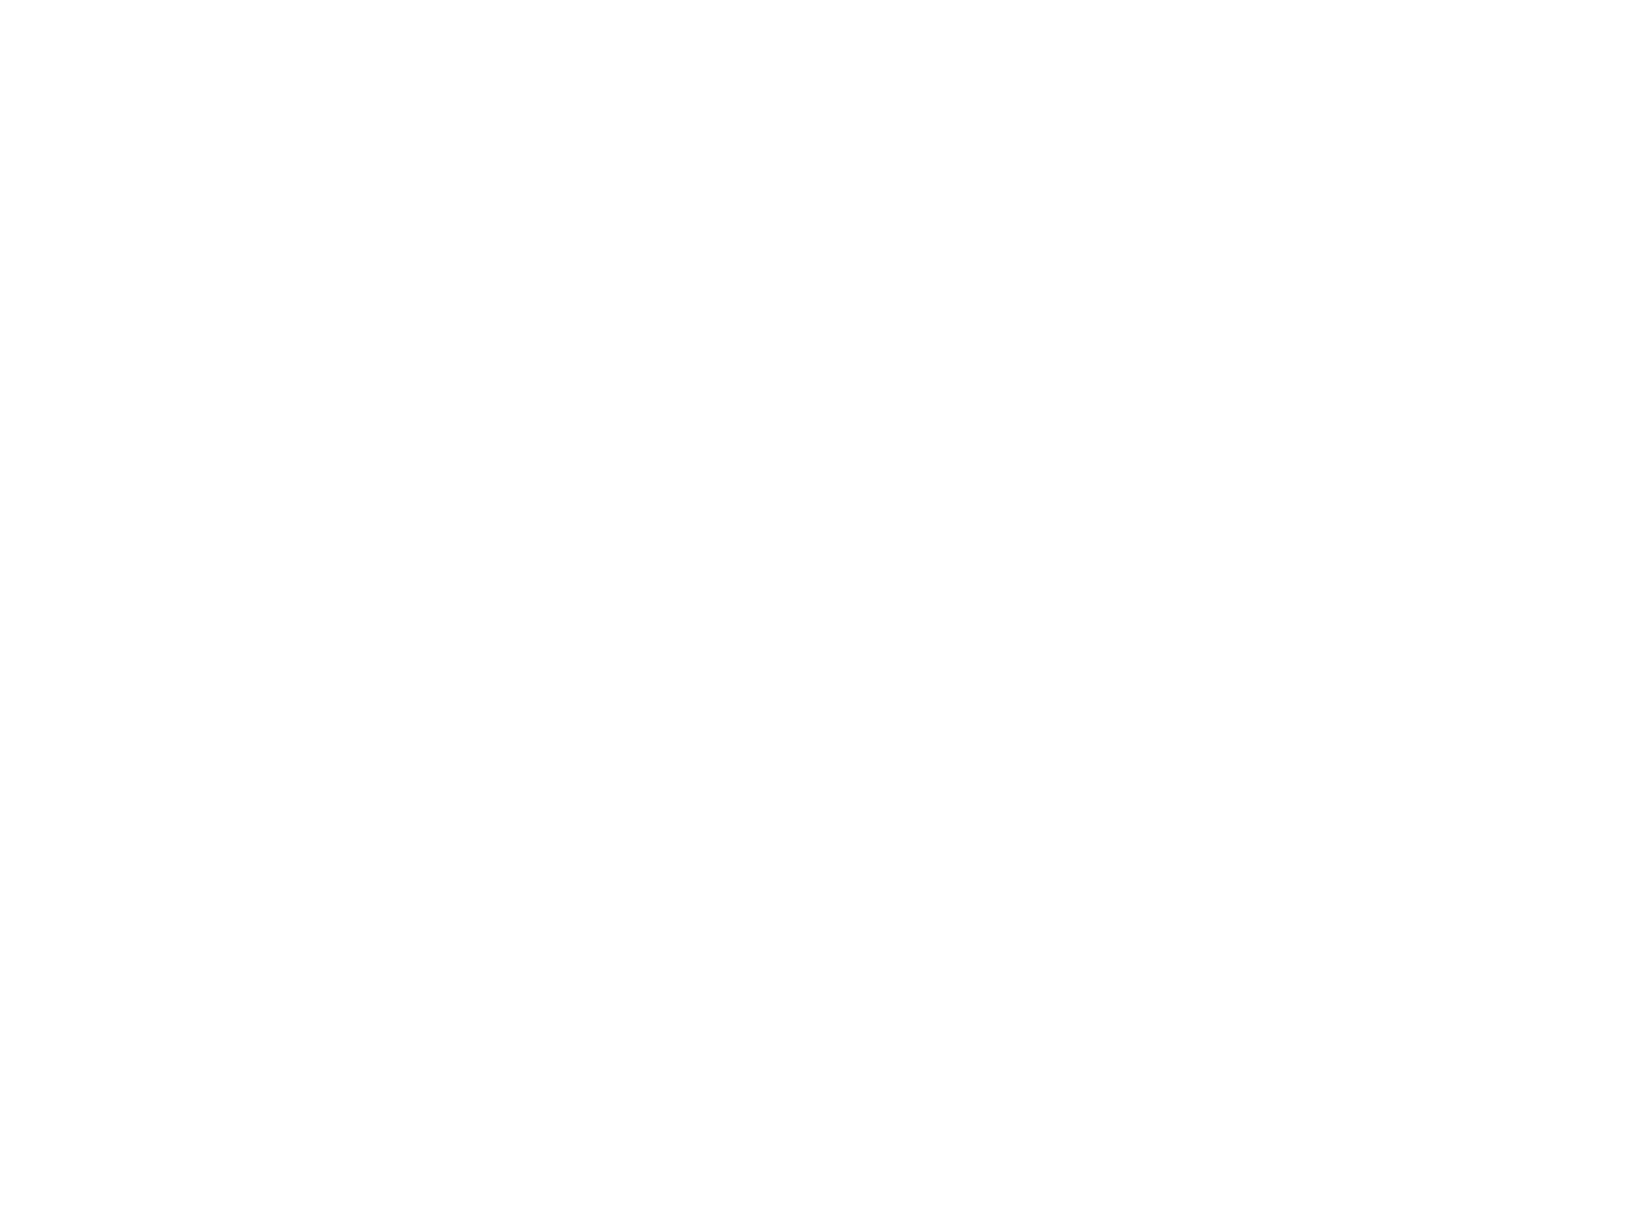

In [ ]:
cv2_imshow(mask)
# cv2_imshow(thresh)
# cv2_imshow(morph)

In [ ]:
# load image
img = cv2.imread('/content/drive/MyDrive/background_subtraction/clean_warped.jpg')
hh, ww = img.shape[:2]

# threshold
lower = (0,200,200)
upper = (50,255,255)
thresh = cv2.inRange(img, lower, upper)

# apply open morphology
#kernel = np.ones((5,5), np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# get bounding box coordinates from largest external contour
contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv2.contourArea)

# draw white filled contour on black background
mask = np.zeros((hh,ww), dtype=np.uint8)
cv2.drawContours(mask, [big_contour], 0, 255, cv2.FILLED)

# compute mean color for region
mean = cv2.mean(img, mask=mask)[0:3]
blue_mean = mean[0]
green_mean = mean[1]
red_mean = mean[2]
print("region_mean_color:", mean)
print("")

# define colors
red = np.array(["red",(0,0,255)],dtype=object)
green = np.array(["green",(0,255,0)],dtype=object)
brown = np.array(["brown",(20,70,140)],dtype=object)
black = np.array(["black",(0,0,0)],dtype=object)
blue = np.array(["blue",(255,0,0)],dtype=object)
yellow = np.array(["yellow",(0,255,255)],dtype=object)

min_rmse = 1000000
colors = np.array([red, green, brown, black, blue, yellow])
print("colorname", "rmse")
for color in colors:
    bb = color[1][0]
    gg = color[1][1]
    rr = color[1][2]
    rmse = math.sqrt( ( (red_mean-rr)*(red_mean-rr) + (green_mean-gg)*(green_mean-gg) + (blue_mean-bb)*(blue_mean-bb) )/3 )
    colorname = color[0]
    print(colorname,rmse)
    if rmse < min_rmse:
        min_rmse = rmse
        match_color = color[0]
print("")
print("match_color:", match_color)
print("rmse:", min_rmse)

# write result to disk
cv2.imwrite("sailboat_thresh.jpg", thresh)
cv2.imwrite("sailboat_morph.jpg", morph)
cv2.imwrite("sailboat_mask.jpg", mask)

# display results
cv2.imshow("THRESH", thresh)
cv2.imshow("MORPH", morph)
cv2.imshow("MASK", mask)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
#@title GIF Generation
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
from IPython.display import Video

n_frames = 10
# create samples distribution with different `std` values
frames_indices = np.append(np.arange(n_frames), np.arange(n_frames)[::-1])
pbar = tqdm(frames_indices, desc ="Generating animation", total=len(frames_indices)-1)
# func which will be applied in order to create a video frame
def func(i):
    plt.gca().clear()
    alpha = i / (n_frames - 1)
    beta = (1.0 - alpha)
    dst = cv2.addWeighted(color0, alpha, warped, beta, 0.0)
    plt.gca().imshow(dst)
    plt.axis('off')

fig = plt.figure(figsize=(6, 6))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
# create the animation using custom func and its parameters (fargs)
ani = animation.FuncAnimation(fig, func, pbar, interval=100,
                              repeat_delay=250, blit=False)

# save the animation into a specific video format
dst_file = './animation_homography.mp4'
ani.save(dst_file)
plt.close()

# custom html attributes set when lauching the video
Video(dst_file, embed=True, html_attributes="muted loop autoplay")

Generating animation:   0%|          | 0/19 [00:00<?, ?it/s]

# Reinhard color transfer

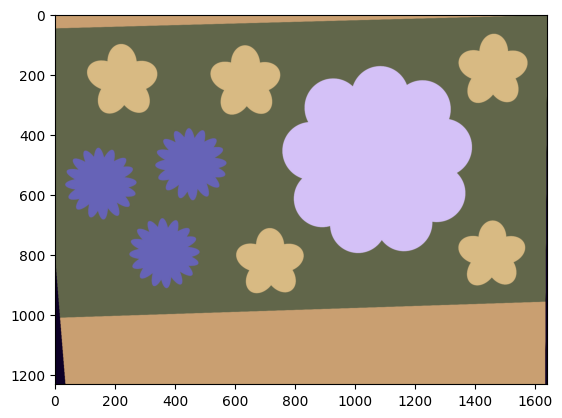

In [ ]:
def get_mean_and_std(x):
	x_mean, x_std = cv2.meanStdDev(x)
	x_mean = np.hstack(np.around(x_mean,2))
	x_std = np.hstack(np.around(x_std,2))
	return x_mean, x_std

#template_img = cv2.imread('template_images/sunset_template.jpg')
'tests/data/Diopsis-flower-screen.jpg'
'tests/data/20230714235848.jpg'
# template_img = cv2.imread('tests/data/20230714235848.jpg')
template_img = color0
template_img = cv2.cvtColor(template_img,cv2.COLOR_RGB2LAB)
template_mean, template_std = get_mean_and_std(template_img)

# input_img = cv2.imread('tests/data/flowers.jpg')
input_img = warped
input_img = cv2.cvtColor(input_img,cv2.COLOR_RGB2LAB)


img_mean, img_std = get_mean_and_std(input_img)


height, width, channel = input_img.shape
for i in range(0,height):
    for j in range(0,width):
        for k in range(0,channel):
            x = input_img[i,j,k]
            x = ((x-img_mean[k])*(template_std[k]/img_std[k]))+template_mean[k]
            x = round(x)
            # boundary check
            x = 0 if x<0 else x
            x = 255 if x>255 else x
            input_img[i,j,k] = x

input_img= cv2.cvtColor(input_img,cv2.COLOR_LAB2RGB)
plt.imshow(input_img)

In [ ]:
cv2.imwrite('/content/drive/MyDrive/background_subtraction/reinhard_warped.jpg', cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))

True

In [ ]:
img1 = Image.open(r'/content/drive/MyDrive/diopsis_coco_split_flowers/20230714235848.jpg')
img2 = Image.open(r'/content/drive/MyDrive/background_subtraction/reinhard_warped.jpg')

diff = ImageChops.difference(img2, img1)
diff.save('/content/drive/MyDrive/background_subtraction/reinhard_diff.jpg')

In [ ]:
diff

Output hidden; open in https://colab.research.google.com to view.

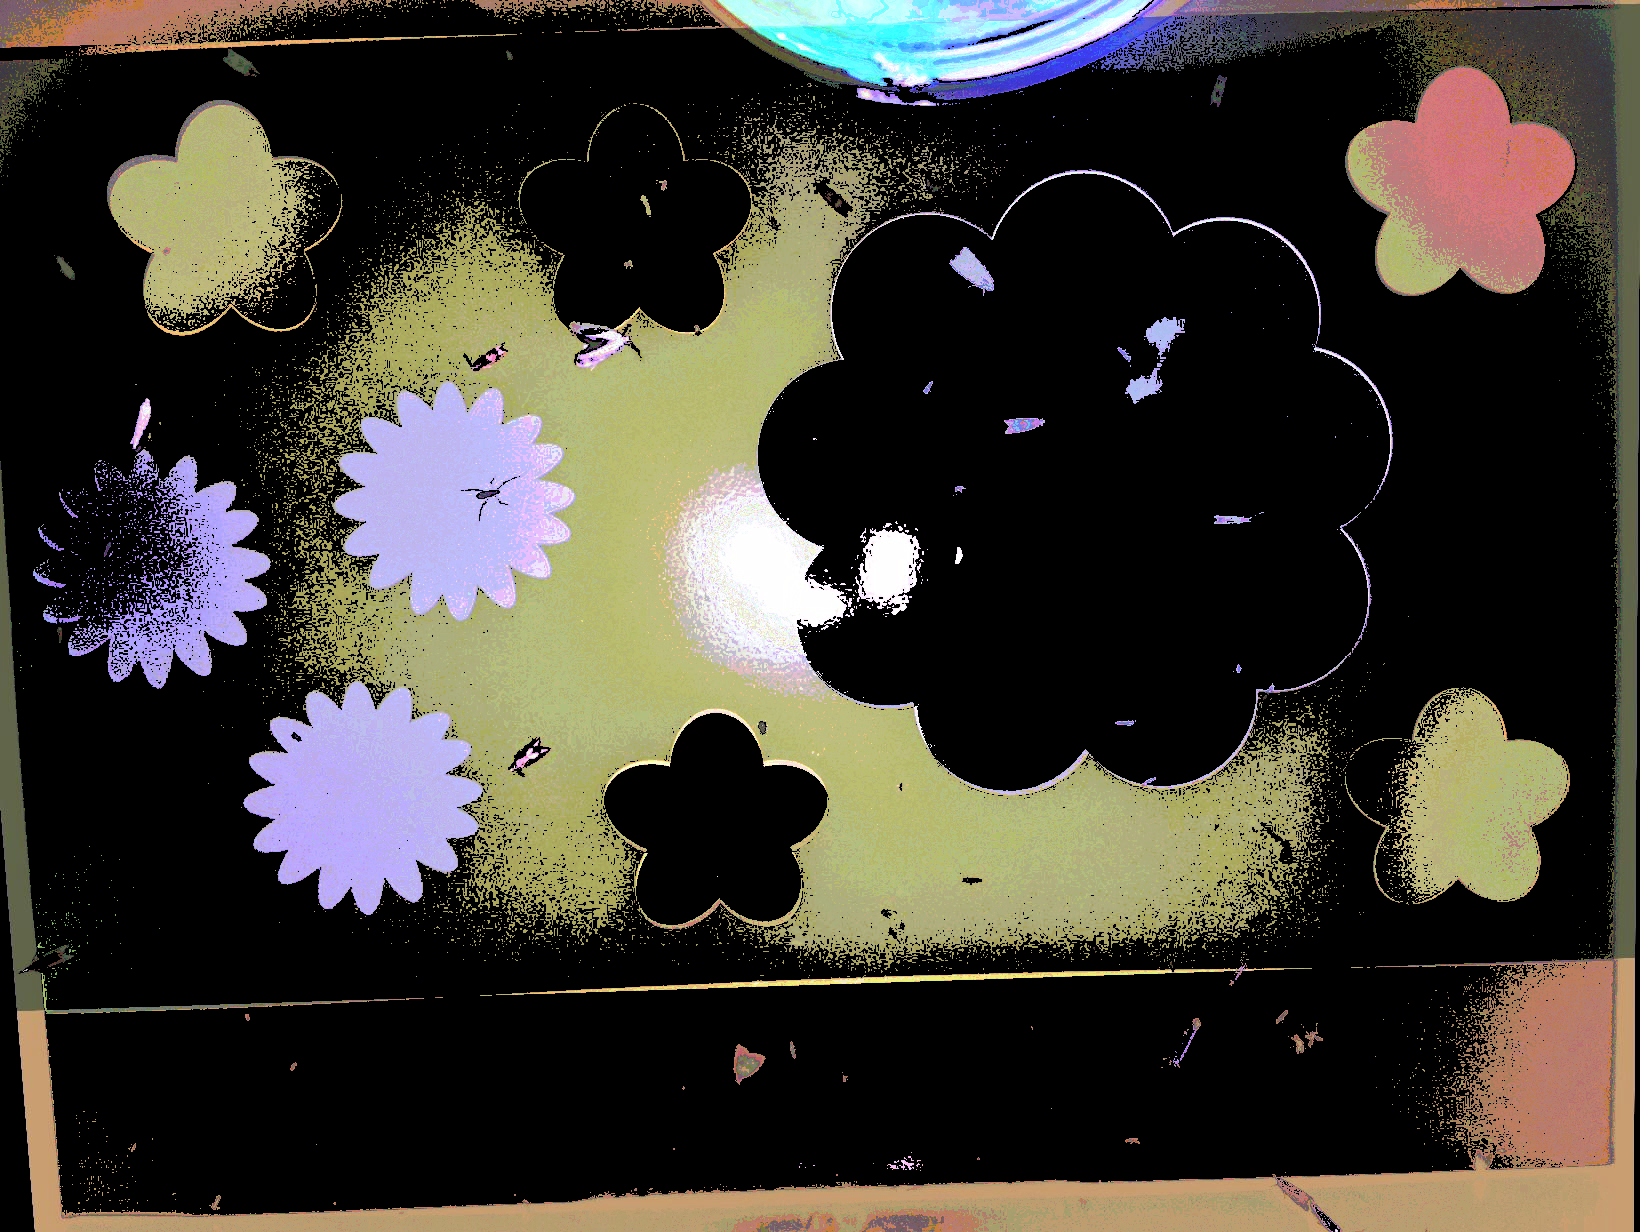

In [ ]:
# Load images
background = cv2.imread('/content/drive/MyDrive/background_subtraction/reinhard_diff.jpg')
insects = cv2.imread('/content/drive/MyDrive/diopsis_coco_split_flowers/20230714235848.jpg')

# Convert images to grayscale
gray_diff = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)

# Threshold the difference to create a binary mask
_, mask = cv2.threshold(gray_diff, 30, 190, cv2.THRESH_BINARY)

# Optionally, apply some morphological operations to clean up the mask
kernel = np.ones((1, 1), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Invert the mask
# mask_inv = mask
mask_inv = cv2.bitwise_not(mask)

# Convert mask to 3 channels to match the input image
# mask_inv_colored = cv2.cvtColor(mask_inv, cv2.COLOR_GRAY2BGR)
mask_colored = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

# Extract the insects using the mask
# insects_foreground = cv2.bitwise_and(insects, mask_inv_colored)
# insects_foreground = cv2.bitwise_and(insects, mask_colored)

# get first masked value (foreground)
fg = cv2.bitwise_or(insects, insects, mask=mask)

# get second masked value (background) mask must be inverted
bk = cv2.bitwise_or(background, background, mask=mask)

# combine foreground+background
final = cv2.bitwise_or(fg, bk)

# Display the result
cv2_imshow(final)

# StainLib test

In [ ]:
url = f"git+https://github.com/sebastianffx/stainlib.git"
!pip install --quiet --upgrade {url}

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 13.5 MB/s eta 0:00:00


In [ ]:
import stainlib
import requests
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from PIL import Image
from io import BytesIO
from stainlib.utils.plot_utils import _plot_imagegrid
from stainlib.normalization.normalizer import ExtractiveStainNormalizer, ReinhardStainNormalizer
from stainlib.utils.stain_utils import is_uint8_image

In [ ]:
from PIL import Image, ImageChops, ImageEnhance

In [ ]:
clean_warp = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/background_subtraction/clean_warped.jpg'), cv2.COLOR_BGR2RGBA)

In [ ]:
normalizer = ReinhardStainNormalizer()
# normalizer = stainlib.normalization.normalizer.ExtractiveStainNormalizer(method='macenko')
# normalizer = stainlib.normalization.normalizer.ExtractiveStainNormalizer(method='vahadane')

# Standardize brightness (This step is optional but can improve the tissue mask calculation)
# target = stainlib.utils.stain_utils.LuminosityStandardizer.standardize(color0)
to_transform = stainlib.utils.stain_utils.LuminosityStandardizer.standardize(clean_warp)
normalizer.fit(color0)
transformed = normalizer.transform(to_transform,mask_background=False)

cv2.imwrite('/content/drive/MyDrive/background_subtraction/stainlib_warped.jpg', cv2.cvtColor(transformed, cv2.COLOR_BGR2RGB))

img1 = Image.open(r'/content/drive/MyDrive/diopsis_coco_split_flowers/20230714235848.jpg')
img2 = Image.open(r'/content/drive/MyDrive/background_subtraction/stainlib_warped.jpg')

diff = ImageChops.difference(img1, img2)
diff

Output hidden; open in https://colab.research.google.com to view.

# color_transfer test

In [ ]:
!pip install color_transfer --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
from color_transfer import color_transfer

In [ ]:
ct = cv2.cvtColor(color_transfer(color0, warped), cv2.COLOR_RGB2RGBA)
cv2.imwrite('/content/drive/MyDrive/background_subtraction/ct_warped.jpg', cv2.cvtColor(ct, cv2.COLOR_BGR2RGB))

img1 = Image.open(r'/content/drive/MyDrive/diopsis_coco_split_flowers/20230714235848.jpg')
img2 = Image.open(r'/content/drive/MyDrive/background_subtraction/ct_warped.jpg')

diff = ImageChops.difference(img1, img2)
diff

Output hidden; open in https://colab.research.google.com to view.

# Inpainting test with premade mask

In [8]:
capture = cv2.imread(mpath+'20230714235848.jpg')
mask = cv2.imread(mpath+'20230714235848mask.jpg', 0)
cleaned_ns0 = cv2.inpaint(capture, mask, 0, cv2.INPAINT_NS)
cleaned_telea0 = cv2.inpaint(capture, mask, 0, cv2.INPAINT_TELEA)
cleaned_ns3 = cv2.inpaint(capture, mask, 3, cv2.INPAINT_NS)
cleaned_telea3 = cv2.inpaint(capture, mask, 3, cv2.INPAINT_TELEA)
cleaned_ns15 = cv2.inpaint(capture, mask, 15, cv2.INPAINT_NS)
cleaned_telea15 = cv2.inpaint(capture, mask, 15, cv2.INPAINT_TELEA)

cv2.imwrite(mpath+'cleaned_ns0.jpg', cleaned_ns0)
cv2.imwrite(mpath+'cleaned_telea0.jpg', cleaned_telea0)
cv2.imwrite(mpath+'cleaned_ns3.jpg', cleaned_ns3)
cv2.imwrite(mpath+'cleaned_telea3.jpg', cleaned_telea3)
cv2.imwrite(mpath+'cleaned_ns15.jpg', cleaned_ns15)
cv2.imwrite(mpath+'cleaned_telea15.jpg', cleaned_telea15)

True

In [14]:
from PIL import Image, ImageChops, ImageEnhance

img = Image.open(r'/content/drive/MyDrive/background_subtraction/20230714235848.jpg')
ns = Image.open(r'/content/drive/MyDrive/background_subtraction/cleaned_ns15.jpg')
telea = Image.open(r'/content/drive/MyDrive/background_subtraction/cleaned_telea15.jpg')

diff_ns = ImageChops.difference(ns, img)
diff_telea = ImageChops.difference(telea, img)

threshold = 7
# Grayscale
diff_ns = diff_ns.convert('L')
diff_telea = diff_telea.convert('L')
# Threshold
diff_ns = diff_ns.point( lambda p: 255 if p > threshold else 0 )
diff_telea = diff_telea.point( lambda p: 255 if p > threshold else 0 )
# # To mono
diff_ns = diff_ns.convert('1')
diff_telea = diff_telea.convert('1')

yellow = Image.new('RGB', (1640, 1232), (255, 236, 10))
result_ns = Image.composite(img, yellow, diff_ns)
result_telea = Image.composite(img, yellow, diff_telea)

In [17]:
result_ns.save(mpath+'yellow_ns.jpg')

In [18]:
result_telea.save(mpath+'yellow_telea.jpg')

In [5]:
!pip install pyinpaint --quiet

In [59]:
capture = mpath+'20230714235848.jpg'
mask = mpath+'20230714235848mask.jpg'
mask_inv = mpath+'20230714235848mask_inv.png'

capture_s = mpath+'20230714235848_small.jpg'
mask_s = mpath+'20230714235848mask_small.jpg'
mask_inv_s = mpath+'20230714235848mask_inv_small.png'

In [64]:
mask_img = cv2.imread(mask)
inv_mask = cv2.bitwise_not(mask_img)
cv2.imwrite(mpath+'20230714235848mask_inv.jpg', inv_mask)
cv2.imwrite(mpath+'20230714235848mask_inv.png', inv_mask)

mask_img = cv2.imread(mask_s)
inv_mask = cv2.bitwise_not(mask_img)
cv2.imwrite(mpath+'20230714235848mask_inv_small.jpg', inv_mask)
cv2.imwrite(mpath+'20230714235848mask_inv_small.png', inv_mask)

True

In [62]:
# mask_img = cv2.imread(mask_inv, 0)
# mask_img = cv2.threshold(mask_img, 127, 1, cv2.THRESH_BINARY)[1]
# cv2.imwrite(mpath+'20230714235848mask_inv.png', mask_img)
mask_img = cv2.imread(mpath+'20230714235848mask_inv_s.png')
# mask_img

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
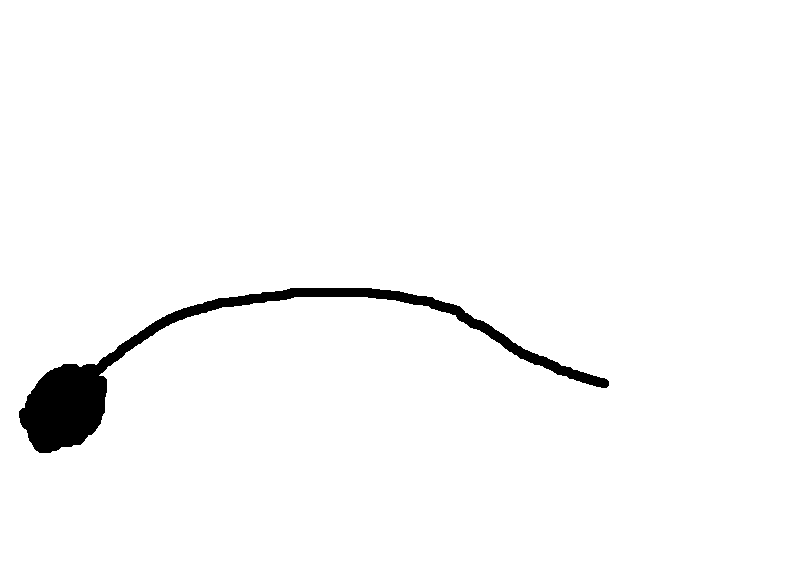

In [55]:
barbara_mask = mpath+'barbara_mask.png'
barbara_mask = cv2.imread(barbara_mask)
barbara_mask

In [66]:
from pyinpaint import Inpaint
inpaint = Inpaint(capture_s, mask_inv_s, ps=9)
inpainted_img = inpaint(k_boundary=8, k_search=1000, k_patch=7)




# of pixels to be inpainted are 46654:   0%|          |0/46654


# of pixels to be inpainted are 46654:  33%|███▎      |15289/46654


# of pixels to be inpainted are 46654:  33%|███▎      |15289/46654


# of pixels to be inpainted are 46654:  50%|█████     |23349/46654


# of pixels to be inpainted are 46654:  50%|█████     |23349/46654


# of pixels to be inpainted are 46654:  62%|██████▏   |28850/46654


# of pixels to be inpainted are 46654:  62%|██████▏   |28850/46654


# of pixels to be inpainted are 46654:  72%|███████▏  |33403/46654


# of pixels to be inpainted are 46654:  72%|███████▏  |33403/46654


# of pixels to be inpainted are 46654:  79%|███████▉  |36821/46654


# of pixels to be inpainted are 46654:  84%|████████▍ |39415/46654


# of pixels to be inpainted are 46654:  89%|████████▉ |41613/46654


# of pixels to be inpainted are 46654:  93%|█████████▎|43507/46654


# of pixels to be inpainted are 46654:  96%|█████████▌|44890/46654


# of pixels to be inpainted are 466

# of pixels to be inpainted are 119829:   0%|          |0/119829


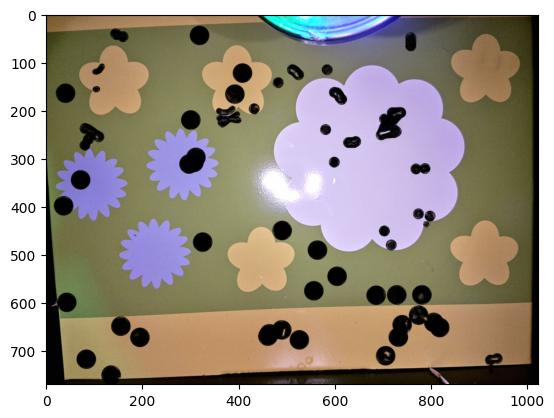

In [67]:
plt.imshow(inpainted_img, cmap="gray")

In [16]:
barbara = mpath+'barbara.jpg'
barbara_mask = mpath+'barbara_mask.png'

inpaint = Inpaint(barbara, barbara_mask, ps=9)
inpainted_img = inpaint(k_boundary=8, k_search=1000, k_patch=7)

# of pixels to be inpainted are 11082: 100%|██████████|11082/11082


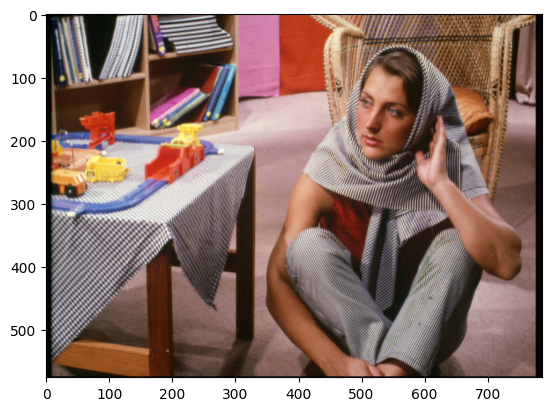

In [19]:
plt.imshow(inpainted_img, cmap="gray")

# Result from **perfect** matches - **BEST CASE SCENARIO**

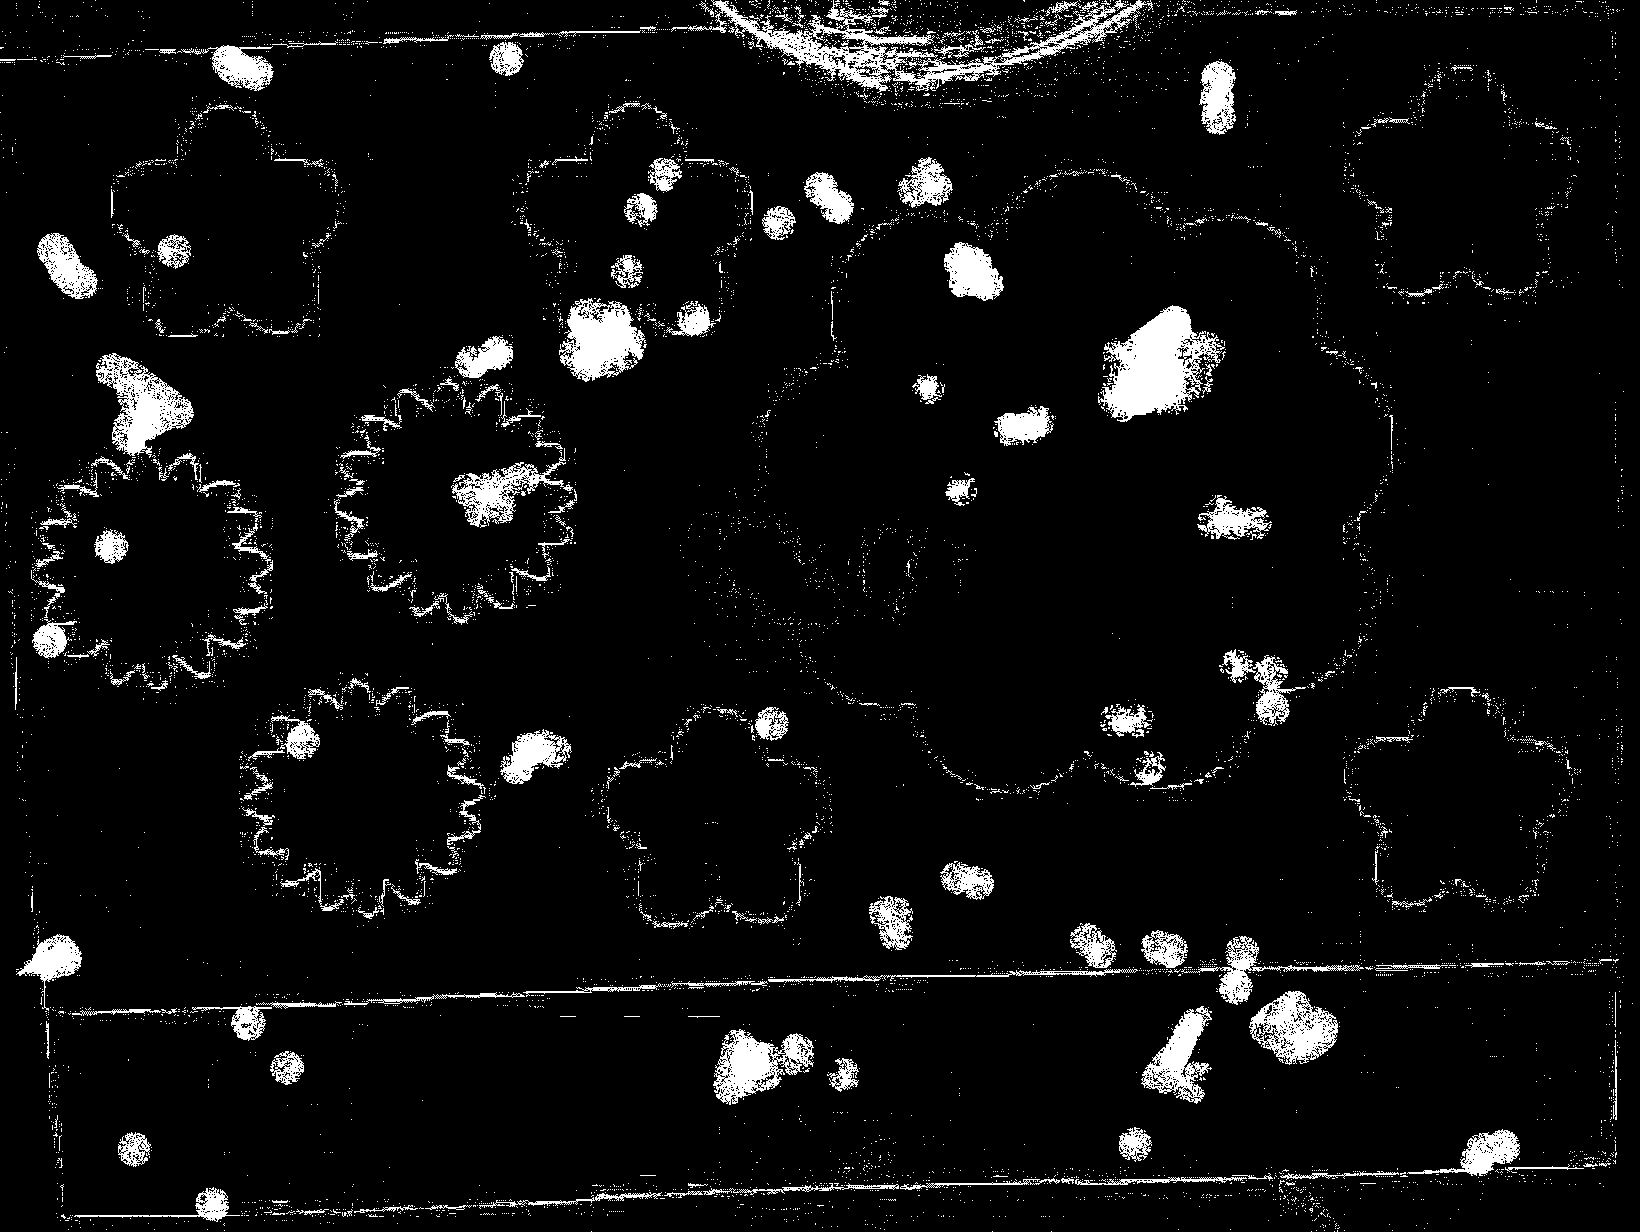

In [ ]:
from PIL import Image, ImageChops, ImageEnhance

img1 = Image.open(r'/content/drive/MyDrive/diopsis_coco_split_flowers/20230714235848.jpg')
img2 = Image.open(r'/content/drive/MyDrive/diopsis_coco_split_flowers/20230714235848copy.jpg')

diff = ImageChops.difference(img2, img1)
diff

threshold = 1
# Grayscale
diff2 = diff.convert('L')
# Threshold
diff2 = diff2.point( lambda p: 255 if p > threshold else 0 )
# To mono
diff2 = diff2.convert('1')
diff2

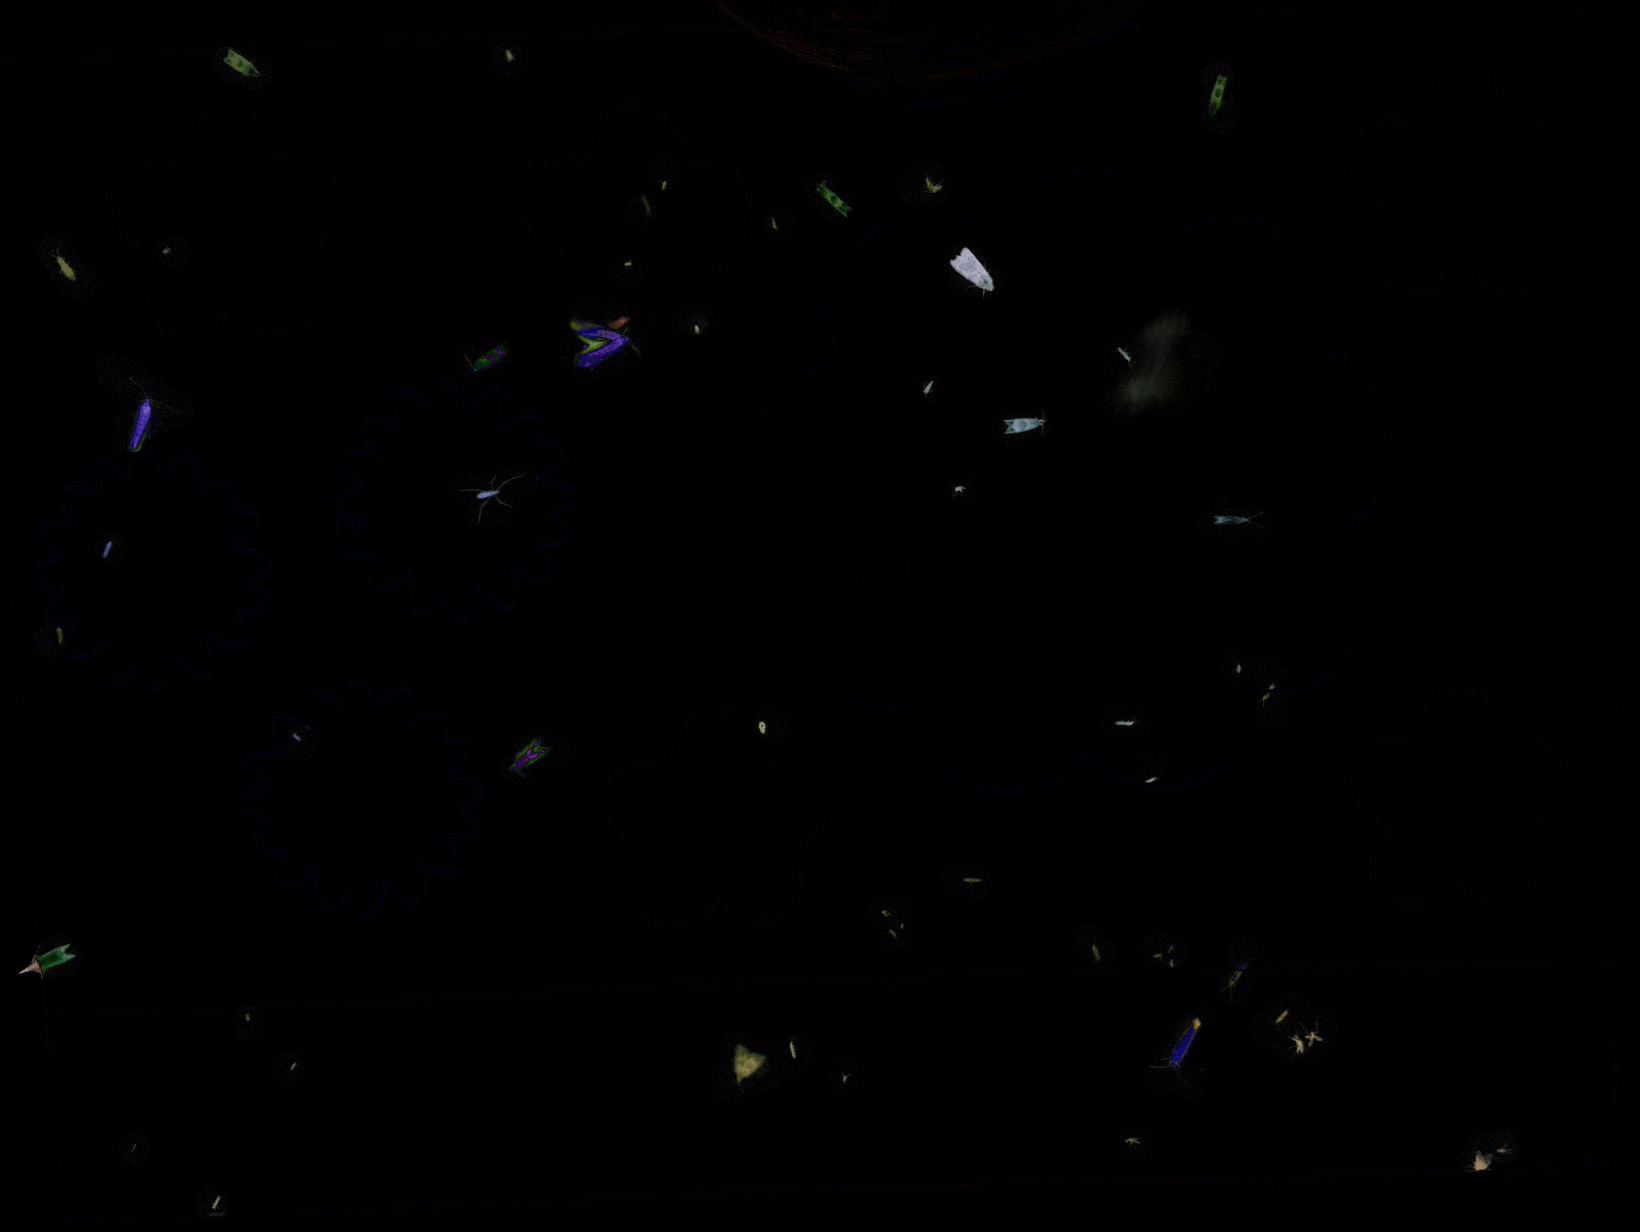

In [ ]:
diff

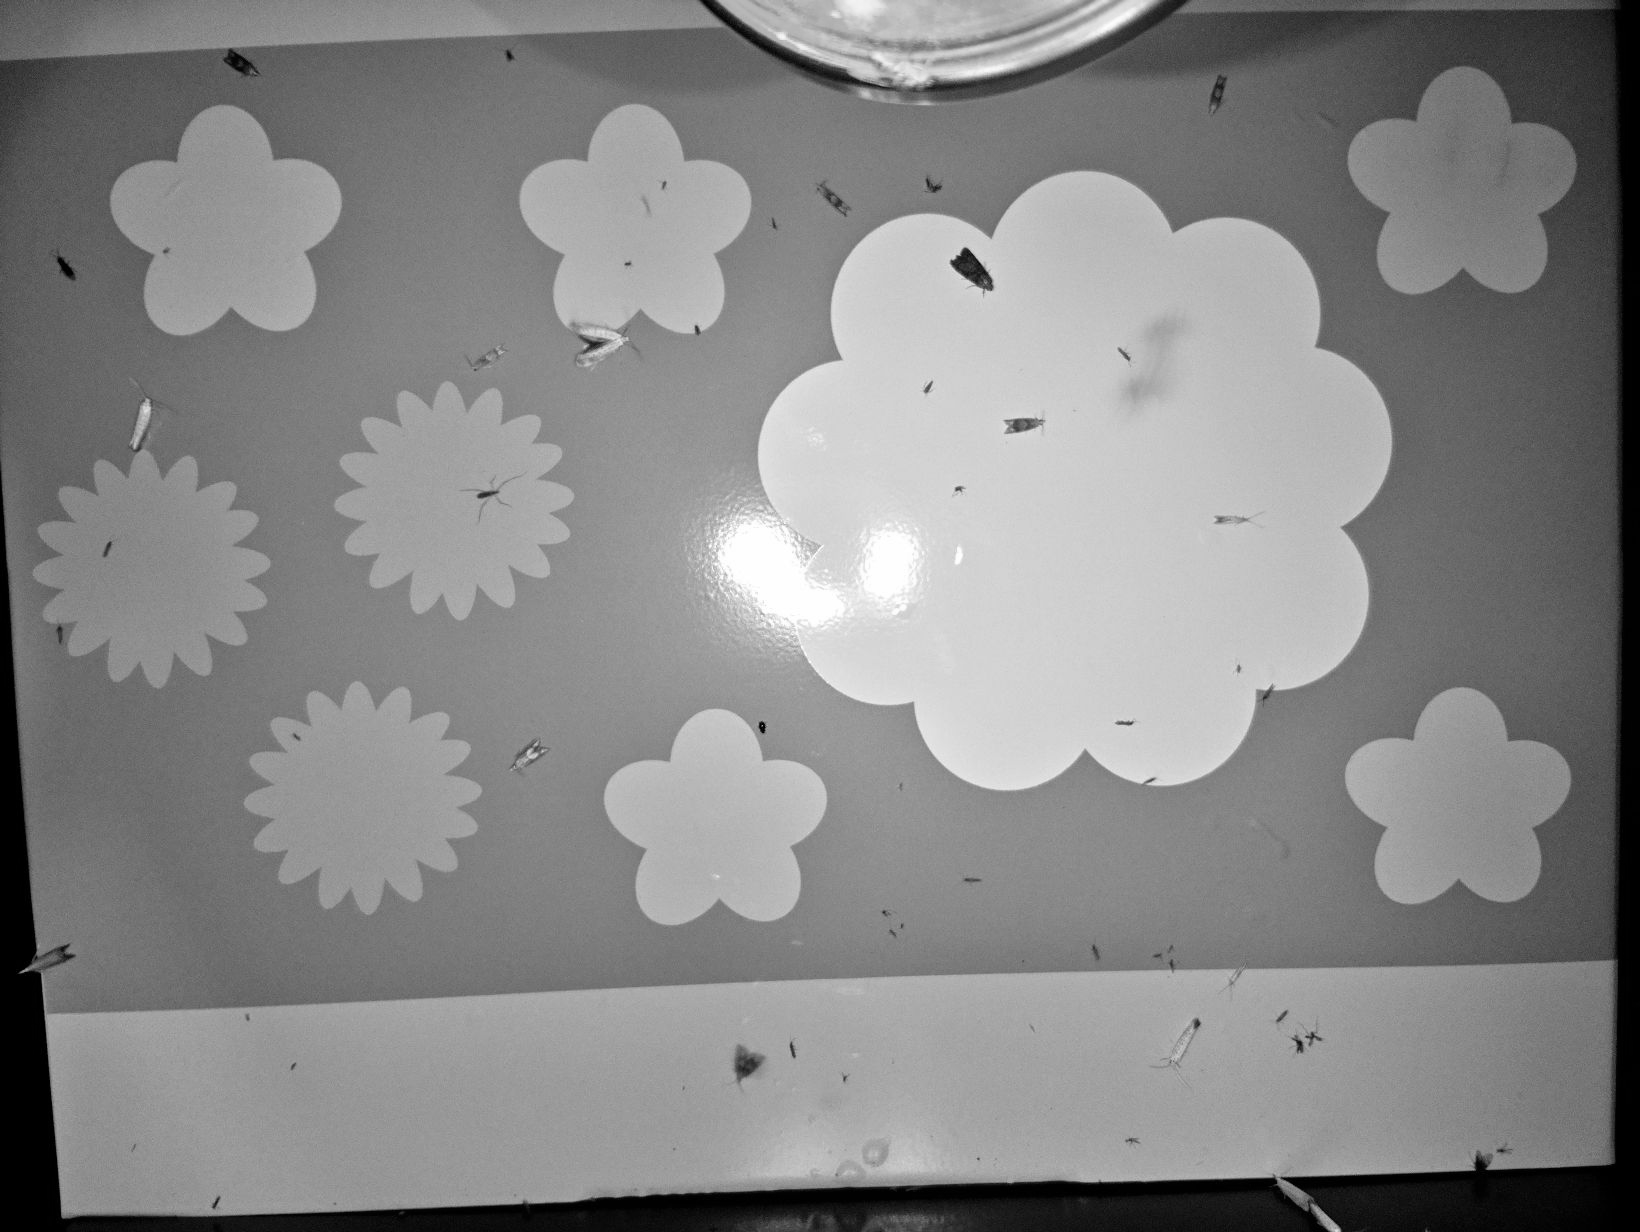

In [ ]:
from PIL import Image, ImageChops, ImageEnhance

img1 = Image.open(r'/content/drive/MyDrive/diopsis_coco_split_flowers/20230714235848.jpg')

# Grayscale
grey = img1.convert('L')
# # To mono
# mono = grey.convert('1'

grey

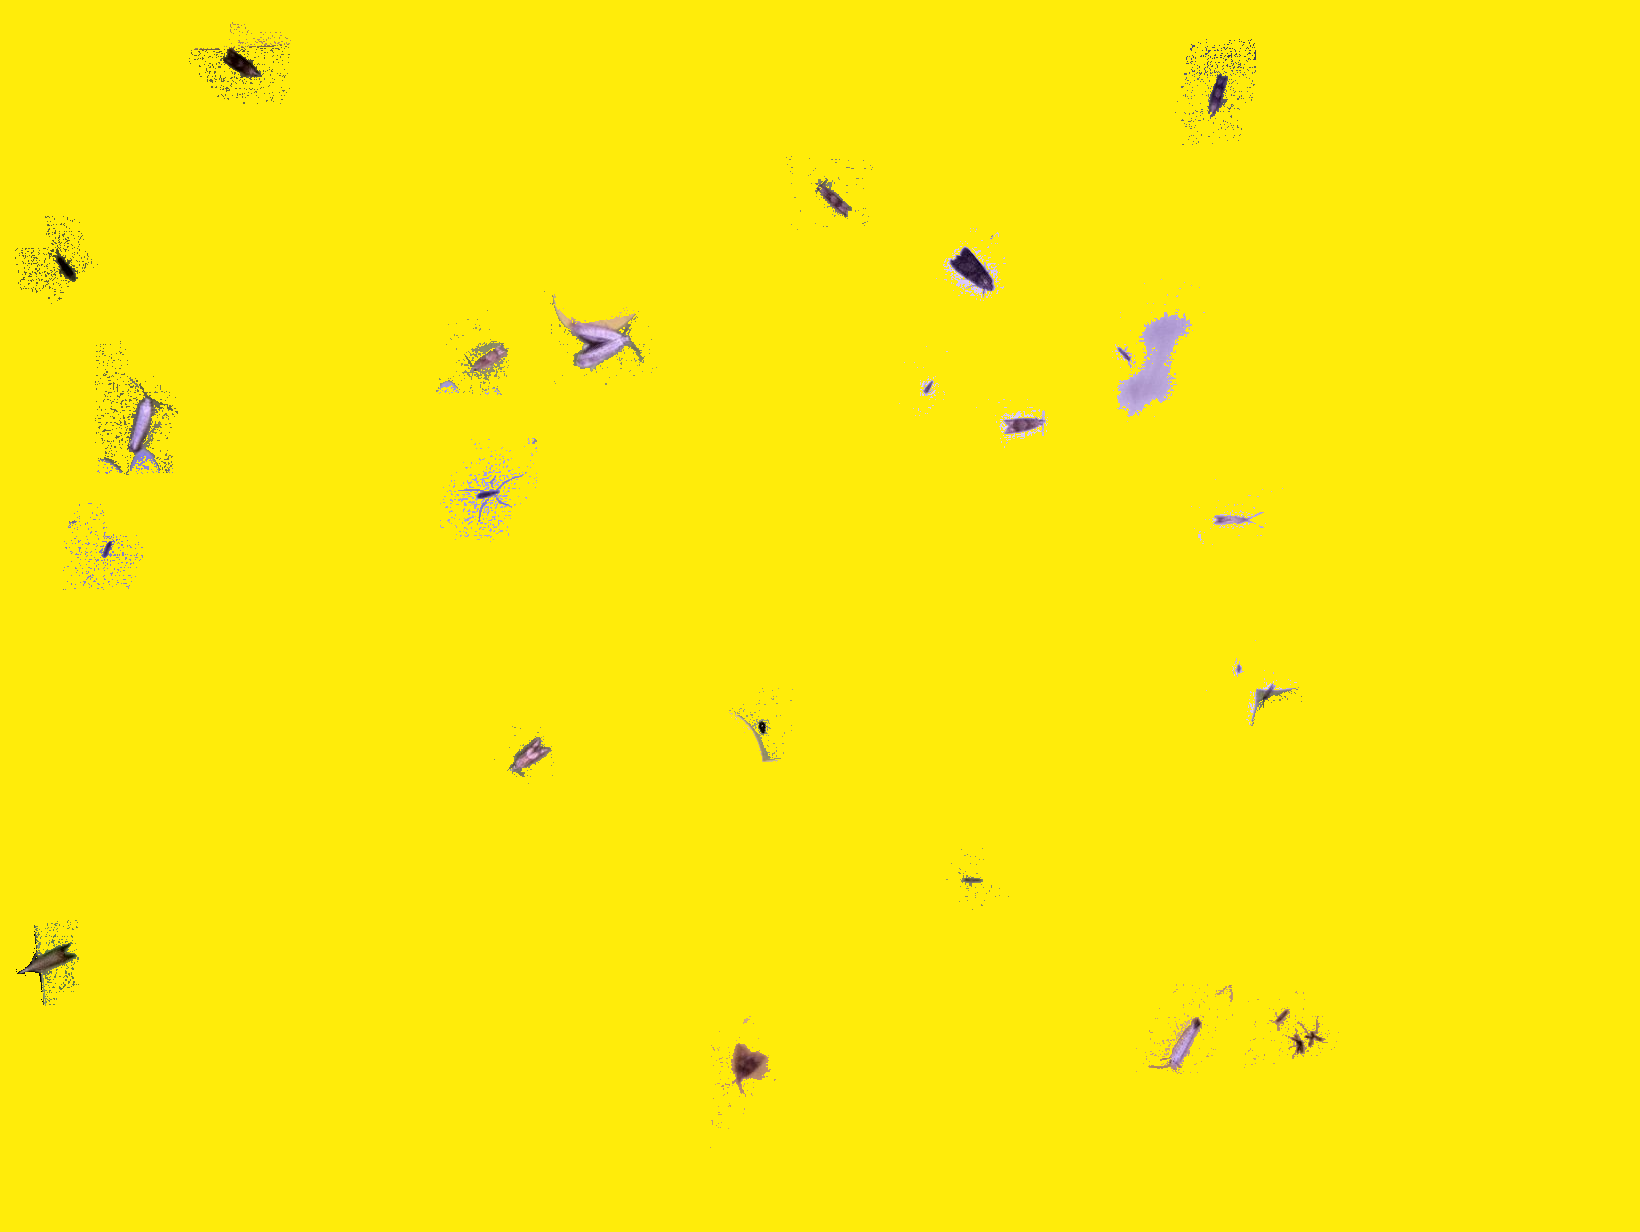

In [4]:
from PIL import Image, ImageChops, ImageEnhance

img1 = Image.open(r'/content/drive/MyDrive/background_subtraction/20230714235848.jpg')
img2 = Image.open(r'/content/drive/MyDrive/background_subtraction/20230714235848_mask.png')

diff = ImageChops.difference(img2, img1)
diff

threshold = 7
# Grayscale
diff2 = diff.convert('L')
# Threshold
diff2 = diff2.point( lambda p: 255 if p > threshold else 0 )
# # To mono
diff2 = diff2.convert('1')
diff2

img3 = Image.new('RGB', (1640, 1232), (255, 236, 10))
diff3 = Image.composite(img1, img3, diff2)

diff3

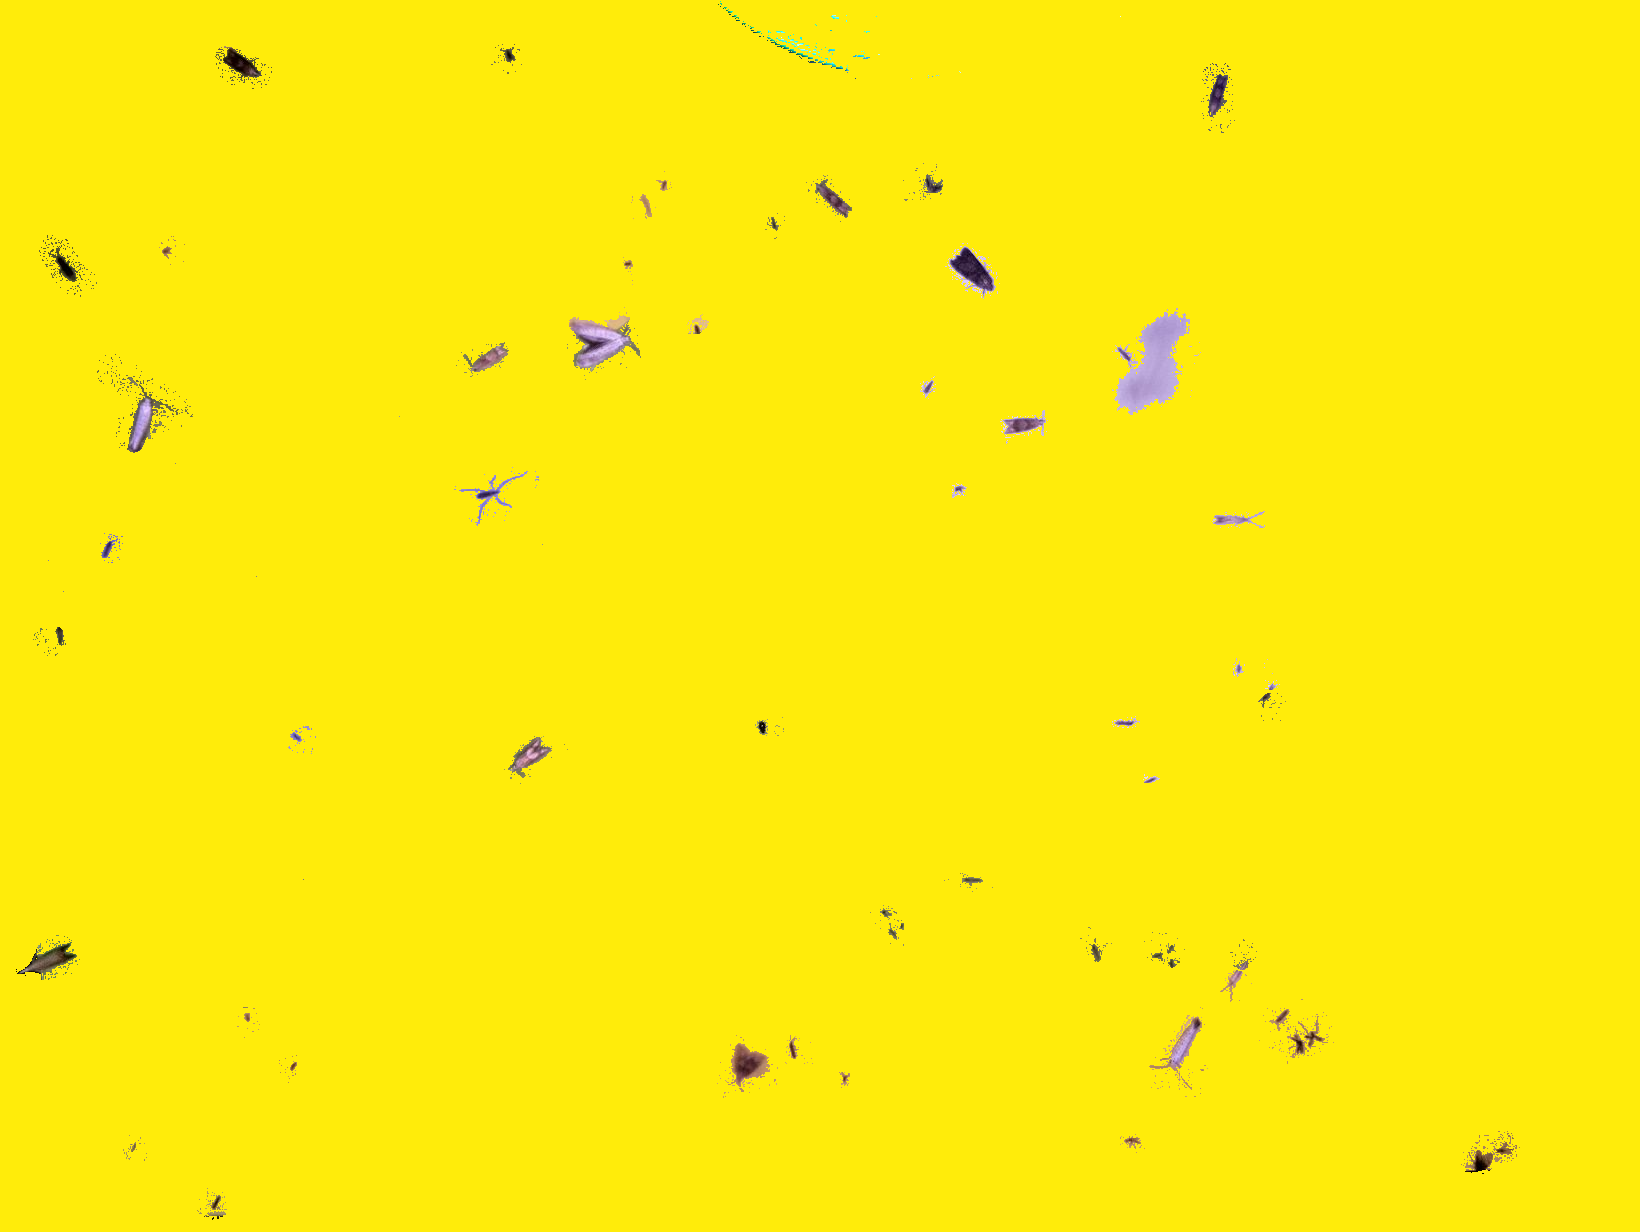

In [20]:
from PIL import Image, ImageChops, ImageEnhance

img1 = Image.open(r'/content/drive/MyDrive/background_subtraction/20230714235848.jpg')
img2 = Image.open(r'/content/drive/MyDrive/background_subtraction/20230714235848copy.jpg')

diff = ImageChops.difference(img2, img1)
diff

threshold = 7
# Grayscale
diff2 = diff.convert('L')
# Threshold
diff2 = diff2.point( lambda p: 255 if p > threshold else 0 )
# # To mono
diff2 = diff2.convert('1')
diff2

img3 = Image.new('RGB', (1640, 1232), (255, 236, 10))
diff3 = Image.composite(img1, img3, diff2)

diff3

In [21]:
diff3.save(mpath+'yellow_best.jpg')

# Grayscale test

In [ ]:
# Load images
background = cv2.imread('/content/drive/MyDrive/background_subtraction/reinhard_warped.jpg')
insects = cv2.imread('/content/drive/MyDrive/diopsis_coco_split_flowers/20230714235848.jpg')

# Convert images to grayscale
gray_background = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
gray_insects = cv2.cvtColor(insects, cv2.COLOR_BGR2GRAY)

# Compute the absolute difference between the background and insects images
difference = cv2.absdiff(gray_background, gray_insects)

# Threshold the difference to create a binary mask
_, mask = cv2.threshold(difference, 30, 190, cv2.THRESH_BINARY)

# # Optionally, apply some morphological operations to clean up the mask
# kernel = np.ones((1, 1), np.uint8)
# mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
# mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Invert the mask
# mask_inv = mask
mask_inv = cv2.bitwise_not(mask)

# Convert mask to 3 channels to match the input image
mask_inv_colored = cv2.cvtColor(mask_inv, cv2.COLOR_GRAY2BGR)

# Extract the insects using the mask
insects_foreground = cv2.bitwise_and(insects, mask_inv_colored)

# Display the result
cv2_imshow(insects_foreground)

# Save the result
# cv2.imwrite('insects_foreground.png', insects_foreground)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
img_path="./combined.png"

combined_img=cv2.imread(img_path)

blurred_img = cv2.GaussianBlur(combined_img, (7, 7), 0)

blurredGray = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2GRAY)

adaptive=cv2.adaptiveThreshold(blurredGray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 1023,5)

plt.imshow(adaptive, cmap="gray")
plt.show()